In [147]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zlib import crc32
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
#from sklearn.pipeline import SimpleImputer

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path=os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz=tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing=load_housing_data()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


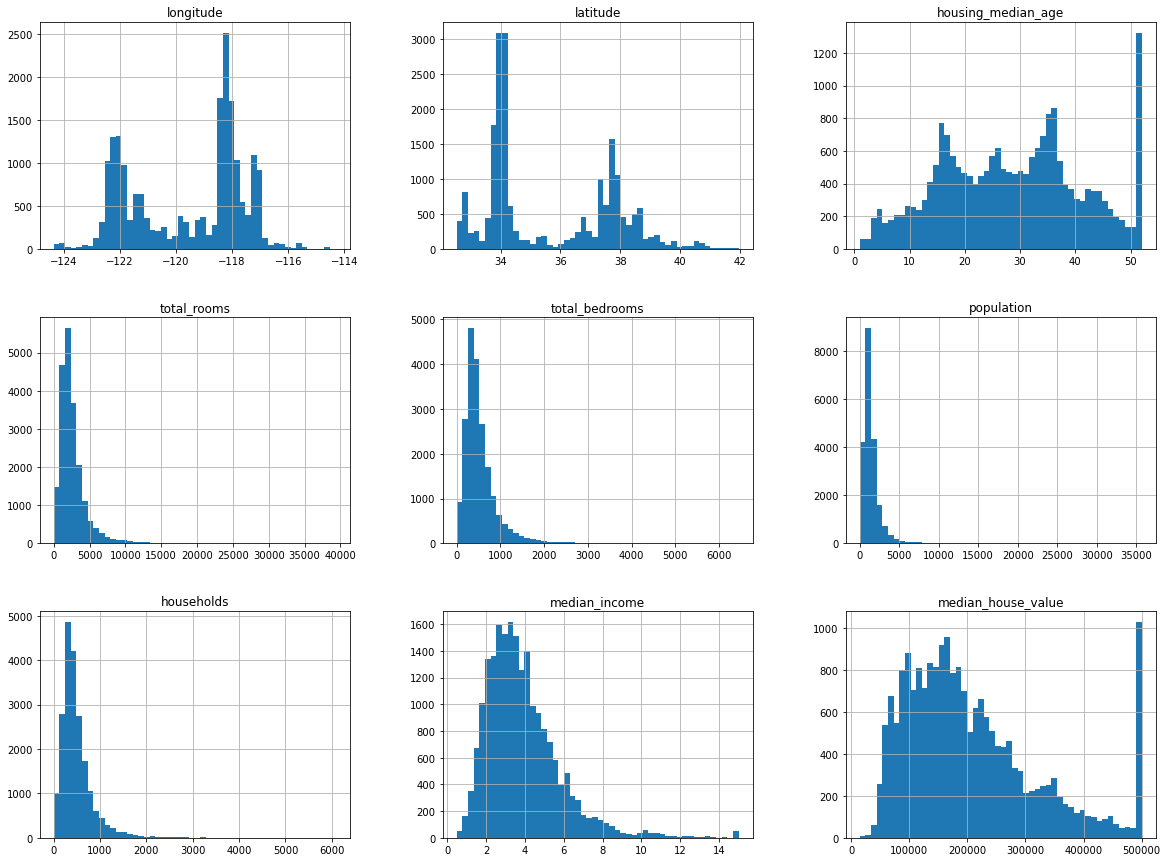

In [11]:
%matplotlib inline
housing.hist(bins=50,figsize=(20,15))
plt.show()

In [12]:
def split_train_test_set(data, test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [13]:
train_set,test_set=split_train_test_set(housing,0.2)

In [14]:
len(train_set)

16512

In [15]:
len(test_set)

4128

In [16]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier))&0xffffffff<test_ratio*2**32

In [17]:
def split_train_test_by_id(data,test_ratio,id_column):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [18]:
housing_with_id=housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"index")

In [19]:
len(train_set)

16512

In [20]:
len(test_set)

4128

<AxesSubplot:>

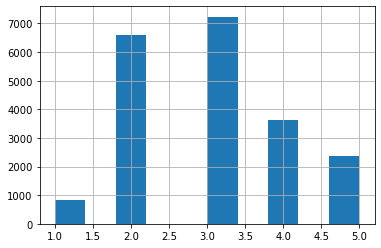

In [21]:
housing["income_cat"]=pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6.0, np.inf],labels=[1,2,3,4,5])
housing["income_cat"].hist()

In [22]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [23]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [24]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,5
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN,4
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN,3
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND,3
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND,3
...,...,...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,76400.0,INLAND,2
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,134000.0,NEAR OCEAN,2
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,311700.0,<1H OCEAN,4
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,133500.0,INLAND,4


In [25]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

In [26]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,76400.0,INLAND
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,134000.0,NEAR OCEAN
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,311700.0,<1H OCEAN
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,133500.0,INLAND


In [27]:
housing=strat_train_set.copy()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,<1H OCEAN


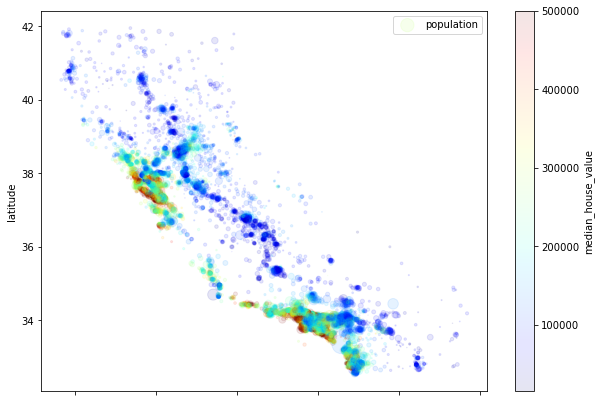

In [49]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1,s=housing["population"]/100,label="population",figsize=(10,7),c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

In [29]:
corr_matrix=housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [30]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

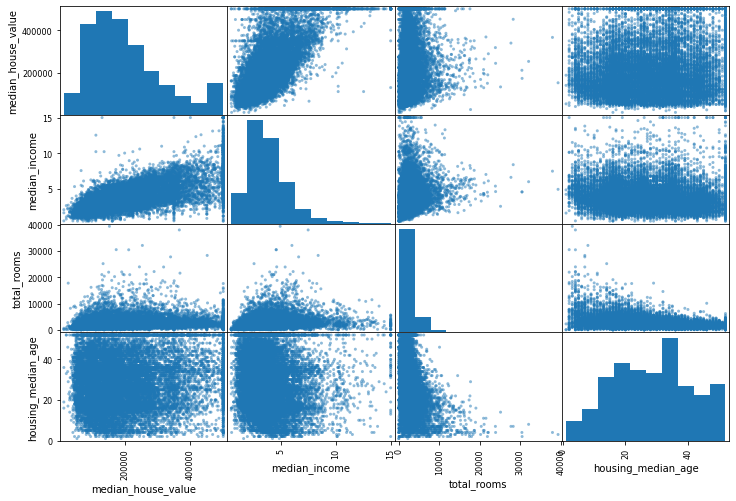

In [31]:
attributes=["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

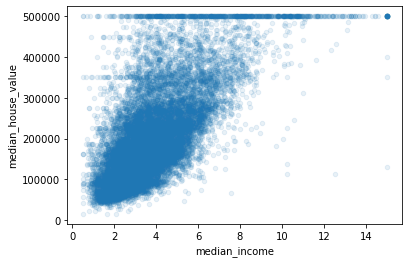

In [32]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

In [33]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [34]:
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [35]:
housing_x=strat_train_set.drop("median_house_value",axis=1)
housing_x_labels=strat_train_set["median_house_value"].copy()

In [36]:
housing_x.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


In [70]:
imputer=SimpleImputer(strategy='median')
housing_num=housing.drop("ocean_proximity",axis=1)

In [71]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [72]:
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11950000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
        1.79500000e+05,  5.23228423e+00,  2.03031374e-01,  2.81765270e+00])

In [73]:
housing_num.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11950000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
        1.79500000e+05,  5.23228423e+00,  2.03031374e-01,  2.81765270e+00])

In [76]:
X=imputer.transform(housing_num)

In [79]:
housing_tr=pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,4.505810,0.231341,3.047847
...,...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,6.052381,0.185681,2.728571
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,4.635659,0.245819,4.077519
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,6.346405,0.179609,2.742484
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,5.505618,0.193878,3.808989


In [80]:
housing_x_cat = housing_x[["ocean_proximity"]]
housing_x_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [88]:
ordinal_encoder = OrdinalEncoder()
housing_x_cat_encoded = ordinal_encoder.fit_transform(housing_x_cat)
housing_x_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [89]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [90]:
cat_encoder = OneHotEncoder()
housing_x_cat_1hot = cat_encoder.fit_transform(housing_x_cat)
housing_x_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [91]:
housing_x_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [92]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [103]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

In [105]:
#Have to look up the variables more closely to debug, custom transformers not working, transformations are basically 
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        rooms_per_household=X[:,rooms_ix]/X[:,households_ix]
        population_per_household=X[:,population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room=X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else: 
            return np.c_[X,rooms_per_household, population_per_household]
attr_adder=CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs=attr_adder.transform(housing.values)

In [106]:
num_pipeline = Pipeline([('imputer',SimpleImputer(strategy="median")),('attribs_adder',CombinedAttributesAdder()),('std_scaler',StandardScaler())])


In [116]:
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('attribs_adder', CombinedAttributesAdder()),
                ('std_scaler', StandardScaler())])

In [107]:
#since the transformation didn't occur in the cell 63, the variable add_bedrooms_per_room hasn't been exectuted so can't be called.
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [109]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [113]:
num_attribs=list(housing_num)
cat_attribs=["ocean_proximity"]
full_pipeline=ColumnTransformer([("num",num_pipeline,num_attribs),("cat",OneHotEncoder(),cat_attribs)])

In [114]:
housing_prepared=full_pipeline.fit_transform(housing)

In [115]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## Select and Train a Model

## Linear Regression Model: sklearns

In [119]:
lin_reg=LinearRegression()
lin_reg.fit(housing_prepared,housing_x_labels)

LinearRegression()

In [162]:
some_data=housing.iloc[:5]
some_labels=housing_x_labels.iloc[:5]
some_data_prepared=full_pipeline.transform(some_data)
print("Predictions:",lin_reg.predict(some_data_prepared))

Predictions: [286600. 340600. 196900.  46300. 254500.]


In [163]:
some_plot_data=housing.iloc[:len(housing)]
some_plot_labels=housing_x_labels.iloc[:len(housing)]
some_plot_data_prepared=full_pipeline.transform(some_data)
print("Predictions:",lin_reg.predict(some_data_prepared))

Predictions: [286600. 340600. 196900.  46300. 254500.]


In [129]:
print("Labels:",list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [133]:
housing_predictions=lin_reg.predict(housing_prepared)
lin_mse=mean_squared_error(housing_x_labels,housing_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

2.3793456390234486e-10

In [135]:
tree_reg=DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_x_labels)

DecisionTreeRegressor()

In [136]:
housing_predictions=tree_reg.predict(housing_prepared)
tree_mse=mean_squared_error(housing_x_labels,housing_predictions)
tree_rmse=np.sqrt(tree_mse)
tree_mse

0.0

In [138]:
scores=cross_val_score(tree_reg,housing_prepared,housing_x_labels,scoring="neg_mean_squared_error",cv=10)

In [139]:
tree_rmse_scores=np.sqrt(-scores)

In [141]:
tree_rmse_scores

array([ 94.55515833, 159.97881216,  96.39158979, 123.76586402,
       101.14427091, 201.36572012, 103.92071711, 132.60197155,
       106.4258841 ,  83.3868191 ])

In [142]:
def display_scores(scores):
    print("Scores:",scores)
    print("Mean:",scores.mean())
    print("Standard deviation:",scores.std())

In [145]:
display_scores(scores)

Scores: [ -8940.6779661  -25593.22033898  -9291.33858268 -15317.98909752
 -10230.16353725 -40548.15324046 -10799.51544518 -17583.28285887
 -11326.46880678  -6953.36159903]
Mean: -15658.417147286184
Standard deviation: 9773.978806981271


In [146]:
lin_scores=cross_val_score(lin_reg,housing_prepared,housing_x_labels,scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores=np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [2.25253570e-10 2.20024962e-10 3.94888002e-10 1.58818990e-10
 2.82709777e-10 2.78529027e-10 2.43659928e-10 2.97652101e-10
 2.37922346e-10 1.37307250e-10]
Mean: 2.47676595109482e-10
Standard deviation: 6.914021705140446e-11


In [148]:
forest_reg=RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_x_labels)

RandomForestRegressor()

In [152]:
forest_scores=cross_val_score(forest_reg,housing_prepared,housing_x_labels,scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores=np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 48.65192376  95.16475977  50.34613684 105.98658613  57.34833578
 271.71605623  74.56081846  59.53330266  55.87822686 114.02176245]
Mean: 93.3207908941862
Standard deviation: 63.59940734525399


In [159]:
housing_forest_predictions=forest_reg.predict(housing_prepared)

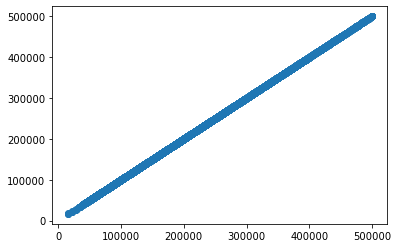

In [160]:
plt.scatter(x=housing["median_house_value"],y=housing_forest_predictions)

In [ ]:
final